In [23]:
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS
from neuralforecast.auto import AutoNHITS
from neuralforecast.losses.pytorch import MSE
import polars as pl
import mlflow
#from mlflow.data.pandas_dataset import PandasDataset
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from datetime import datetime
from dateutil.relativedelta import relativedelta
import plotly.express as px
from pyecharts.charts import Line, Page
import pyecharts.options as opts
import plotly.io as pio
from sklearn.metrics import silhouette_score

pio.templates.default='plotly_white'

idf = pl.read_parquet("C:\\Users\\smishra14\\setup\\repos\\fcst\\data\\Trauma.parquet")
df= idf.filter(pl.col('SALES_DATE')<=datetime.today()-relativedelta(months=1))

In [ ]:
def prepare_data(df):
    columns_to_drop = [
        'UOM', 'NPI Flag', 'Pack Content', '`L0 ASP Final Rev',
        'Act Orders Rev Val', 'L2 DF Final Rev', 'L1 DF Final Rev',
        'L0 DF Final Rev', 'L2 Stat Final Rev', '`Fcst DF Final Rev',
        '`Fcst Stat Final Rev', '`Fcst Stat Prelim Rev', 'Fcst DF Final Rev Val'
    ]
    df = df.drop([col for col in columns_to_drop if col in df.columns])
    df = df.fill_nan(0)
    #df["unique_id"] = df['Country'].astype(str) + "," + df['CatalogNumber'].astype(str)
    df=df.with_columns(unique_id = pl.col('Country') + "," + pl.col('CatalogNumber'))
    df = df.with_columns(num=pl.col('`Act Orders Rev').count().over('CatalogNumber'))
    return df
    
dft = prepare_data(df)
df_fr = dft.rename({'SALES_DATE': 'ds', '`Act Orders Rev': 'y'})
df_fr=df_fr.with_columns(ds = pl.col('ds').cast(pl.Datetime))
df_fr=df_fr.with_columns(y = pl.col('y').cast(pl.Float32))
df_fr = df_fr[['unique_id', 'ds', 'y']]
df_fr=df_fr.sort('ds')
#df_fr= df_fr.with_columns(ymean=pl.col('y').rolling_mean(3).over('unique_id'))
#dfr= df_fr.with_columns(ydiff=pl.col('y').diff().over('unique_id'))
dfr=df_fr.with_columns(ynorm=((pl.col('y')-pl.col('y').mean()) / pl.col('y').std()).over('unique_id'))
#dfr=dfr.with_columns(ynorm=((pl.col('ydiff')-pl.col('ydiff').mean()) / pl.col('ydiff').std()).over('unique_id'))
dfr=dfr.fill_nan(0)
dfr=dfr.pivot(index='unique_id',on='ds',values='ynorm',aggregate_function='sum')

In [25]:
#dfp=df_fr.filter(pl.col('num')>34)
from sklearn.cluster import KMeans
km=KMeans(max_iter=800,n_clusters=6).fit(dfr[:,1:])
dfp=dfr.with_columns(kmeans=km.labels_)
dfp=dfp['unique_id','kmeans']
dfi = idf.with_columns(unique_id = pl.col('Country') + "," + pl.col('CatalogNumber'))
dfi = dfi.drop('kmeans',strict=False)
dfi=dfi.join(dfp,on='unique_id')
silhouette_score(dfp[:,1:],km.labels_)

1.0

In [26]:
from sklearn.cluster import Birch
bi=Birch(n_clusters=6).fit(dfr[:,1:])
dfp=dfr.with_columns(birch=bi.labels_)
dfp=dfp['unique_id','birch']
dfi=dfi.drop('birch',strict=False)
dfi=dfi.join(dfp,on='unique_id')
#dfi.write_csv('Trauma-US.csv')
silhouette_score(dfp[:,1:],bi.labels_)

1.0

In [27]:
dfi=dfi.join(dfp,on='unique_id')
dfi.write_csv('Trauma-US.csv')

In [28]:
df=pl.read_parquet('C:\\Users\\smishra14\\setup\\repos\\fcst\\data\\Triathlon Primary.parquet')
df

Selling Division,Area,Stryker Group Region,Region,Country,CatalogNumber,Business Sector,Business Unit,Franchise,Product Line,IBP Level 5,IBP Level 6,IBP Level 7,SALES_DATE,UOM,Pack Content,`L0 ASP Final Rev,`Act Orders Rev,Act Orders Rev Val,L2 DF Final Rev,L1 DF Final Rev,L0 DF Final Rev,L2 Stat Final Rev,`Fcst DF Final Rev,`Fcst Stat Final Rev,`Fcst Stat Prelim Rev,Fcst DF Final Rev Val,unique_id
str,str,str,str,str,str,str,str,str,str,str,str,str,datetime[μs],"decimal[20,10]",i32,"decimal[38,8]",f32,"decimal[38,8]",f32,"decimal[38,8]","decimal[38,8]",f32,f32,f32,f32,"decimal[38,8]",str
"""SOUTH PACIFIC""","""South Pacific""","""APAC""","""South Pacific""","""AUSTRALIA""","""5530-G-009-E""","""Orthopaedics and Spine""","""Implants""","""Joint Replacement""","""Knees""","""Triathlon Primary""","""Triathlon CR X3 Insert""","""5530-GE""",2022-08-01 00:00:00,1.0000000000,1,null,null,null,null,null,null,null,null,null,null,0.00000000,"""AUSTRALIA,5530-G-009-E"""
"""SOUTH PACIFIC""","""South Pacific""","""APAC""","""South Pacific""","""AUSTRALIA""","""5550-G-278-E""","""Orthopaedics and Spine""","""Implants""","""Joint Replacement""","""Knees""","""Triathlon Primary""","""Triathlon Symmetric X3 Patella""","""5550-GE""",2022-08-01 00:00:00,1.0000000000,1,2040.47453753,31.0,8134.29439657,41.775326,42.07191518,42.05270607,23.598019,null,null,null,0.00000000,"""AUSTRALIA,5550-G-278-E"""
"""SOUTH PACIFIC""","""South Pacific""","""APAC""","""South Pacific""","""AUSTRALIA""","""5550-G-278""","""Orthopaedics and Spine""","""Implants""","""Joint Replacement""","""Knees""","""Triathlon Primary""","""Triathlon Symmetric X3 Patella""","""5550-G""",2022-08-01 00:00:00,1.0000000000,1,2144.55717861,1.0,316.35813796,6.239691,6.94103184,6.93786272,4.0,null,null,null,0.00000000,"""AUSTRALIA,5550-G-278"""
"""SOUTH PACIFIC""","""South Pacific""","""APAC""","""South Pacific""","""AUSTRALIA""","""5551-G-299""","""Orthopaedics and Spine""","""Implants""","""Joint Replacement""","""Knees""","""Triathlon Primary""","""Triathlon Asymmetric X3 Patell…","""5551-G""",2022-08-01 00:00:00,1.0000000000,1,2967.45235213,2.0,573.26149826,null,5.62889420,5.62889420,1.117136,null,null,null,0.00000000,"""AUSTRALIA,5551-G-299"""
"""SOUTH PACIFIC""","""South Pacific""","""APAC""","""South Pacific""","""AUSTRALIA""","""5530P109""","""Orthopaedics and Spine""","""Implants""","""Joint Replacement""","""Knees""","""Triathlon Primary""","""Triathlon CR Insert""","""5530P""",2022-08-01 00:00:00,1.0000000000,1,2969.66663471,null,null,null,null,null,null,null,null,null,0.00000000,"""AUSTRALIA,5530P109"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""SOUTH PACIFIC""","""South Pacific""","""APAC""","""South Pacific""","""NEW ZEALAND""","""5531-G-819-E""","""Orthopaedics and Spine""","""Implants""","""Joint Replacement""","""Knees""","""Triathlon Primary""","""Triathlon CS X3 Insert""","""5531-GE""",2027-07-01 00:00:00,1.0000000000,1,null,null,null,null,null,null,null,0.0,null,null,0.00000000,"""NEW ZEALAND,5531-G-819-E"""
"""SOUTH PACIFIC""","""South Pacific""","""APAC""","""South Pacific""","""NEW ZEALAND""","""5531G313E""","""Orthopaedics and Spine""","""Implants""","""Joint Replacement""","""Knees""","""Triathlon Primary""","""Triathlon CS X3 Insert""","""5531-GE""",2027-07-01 00:00:00,1.0000000000,null,543.74484151,null,null,0.052061,0.00000000,0.00000000,0.052061,0.0,0.0,0.0,0.00000000,"""NEW ZEALAND,5531G313E"""
"""SOUTH PACIFIC""","""South Pacific""","""APAC""","""South Pacific""","""NEW ZEALAND""","""5531G313E""","""Orthopaedics and Spine""","""Implants""","""Joint Replacement""","""Knees""","""Triathlon Primary""","""Triathlon CS X3 Insert""","""5531-GE""",2027-07-01 00:00:00,1.0000000000,1,543.74484151,null,null,0.052061,0.00000000,0.00000000,0.052061,0.0,0.0,0.0,0.00000000,"""NEW ZEALAND,5531G313E"""


Text(0.5, 0, 'Epsilon distance')

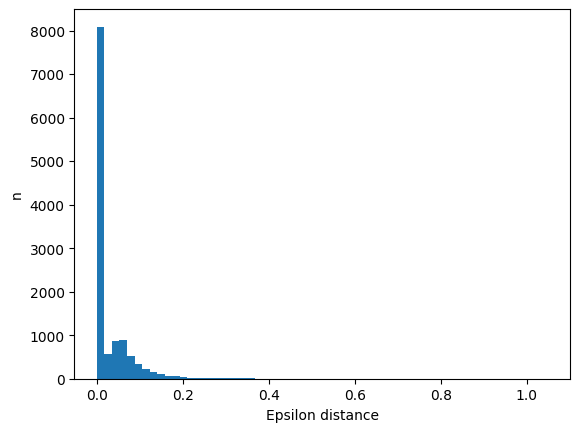

In [67]:
import matplotlib.pyplot as plt
import math
dfp=df_fr.with_columns(ynorm=((pl.col('y')-pl.col('y').mean()) / pl.col('y').std()).over('unique_id'))
dfp=dfp.fill_nan(0)
dfp=dfp.pivot(index='unique_id',on='ds',values='ynorm',aggregate_function='sum')
def calculate_kn_distance(X,k):
    kn_distance = []
    for i in range(len(X)):
        eucl_dist = []
        for j in range(len(X)):
            eucl_dist.append(
                math.sqrt(
                    ((X[i,0] - X[j,0]) ** 2) +
                    ((X[i,1] - X[j,1]) ** 2)))
        eucl_dist.sort()
        kn_distance.append(eucl_dist[k])
    return kn_distance
eps_dist = calculate_kn_distance(dfp[:,1:].to_numpy(),4)
plt.hist(eps_dist,bins=60)
plt.ylabel('n')
plt.xlabel('Epsilon distance')

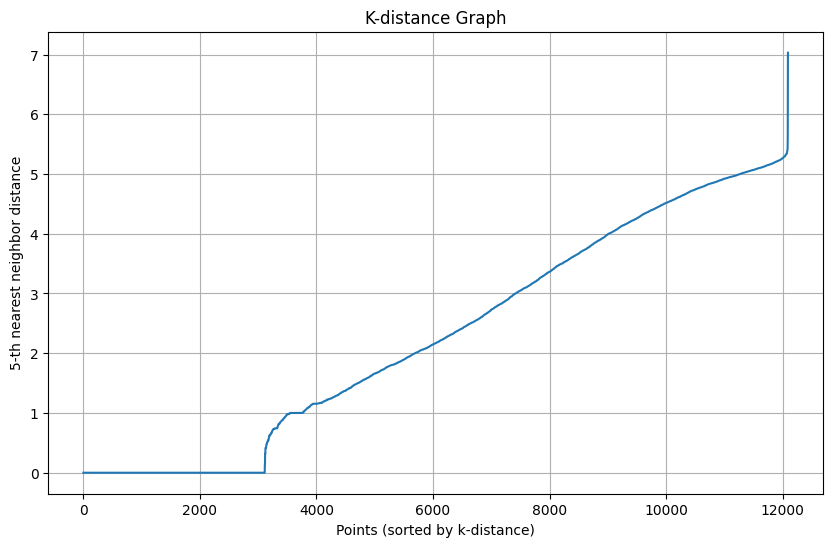

In [80]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
k = 5  # Choose a value for k (often set to MinPts in DBSCAN)
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(dfr[:,1:])
distances, _ = neigh.kneighbors(dfr[:,1:])
k_distances = np.sort(distances[:, k-1])
plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.xlabel('Points (sorted by k-distance)')
plt.ylabel(f'{k}-th nearest neighbor distance')
plt.title('K-distance Graph')
plt.grid(True)

In [5]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=.2,min_samples=20).fit(dfr[:,1:])
dfp=dfr.with_columns(dbscan=db.labels_)
dfp=dfp['unique_id','dbscan']
#if 'dbscan' in dfi.columns:
dfi=dfi.drop('dbscan',strict=False)
dfi=dfi.join(dfp,on='unique_id')
dfi.write_csv('Trauma-US.csv')

In [83]:
silhouette_score(dfp[:,1:],db.labels_)

1.0

In [ ]:
df1=df_fr.join(dfp,on='unique_id')
page= Page()
for c in df1['cluster'].unique():
    bar = Line()
    bar.add_xaxis(df1['ds'].unique().to_list())
    dd=df1.filter(pl.col('cluster')==c).sort('ds')
    for i in dd['unique_id'].unique():
        bar.add_yaxis(i,dd.filter(pl.col('unique_id')==i)['y'].to_list(),label_opts=opts.LabelOpts(is_show=False))
    bar.set_global_opts(title_opts=opts.TitleOpts(title="Cluster "+str(c)),legend_opts=opts.LegendOpts(is_show=False),
                        datazoom_opts=opts.DataZoomOpts(is_show=True,yaxis_index=0,orient='vertical',range_start=0,range_end=100),
                        )
    page.add(bar)
    page.page_title='Trauma US'
page.render('charts.html')

'c:\\Users\\smishra14\\setup\\repos\\fcst\\archive\\charts.html'

In [88]:
px.line(df1.filter(pl.col('cluster')==3).sort('ds'),x='ds',y='y',color='unique_id',facet_col_wrap=2,height=500)

In [ ]:
import numpy as np
from statsmodels.tsa.seasonal import STL 
results=[]
def seasonal_strength(ts_data,unique_id_val):
    stl = STL(ts_data['y'], period=12, robust=True)
    decomposition = stl.fit()
    seasonal_var = np.var(decomposition.seasonal)
    remainder_var = np.var(decomposition.resid)
    #remainder_var = np.var(decomposition.resid+seasonal_var)
    if seasonal_var + remainder_var == 0:
        seasonal_strength = 0.0
    else:
        seasonal_strength = seasonal_var / (seasonal_var + remainder_var)
        #seasonal_strength = seasonal_var / remainder_var
    #seasonal_strength = max(0.0, min(1.0, seasonal_strength))
    results.append({'unique_id': unique_id_val,'seasonal_strength': seasonal_strength,'n_periods': len(ts_data)})
    return results
for i in df_fr['unique_id'].unique():
    seasonal_strength(df_fr.filter(pl.col('unique_id')==i),i)
results=pl.DataFrame(results)
results=results.fill_nan(0).sort('seasonal_strength',descending=True)

In [4]:
pdf = df_fr.with_columns(month = pl.col('ds').dt.month())
pdf = pdf.with_columns(year=pl.col('ds').dt.year())
for i in pdf['unique_id'].unique():
    dd=pdf.with_columns(year=pl.when(pl.col('year')==2025).then(2022).otherwise(pl.col('year')))
    dd=dd.with_columns(pl.col('month').cast(pl.Utf8))
    dd=dd.filter(pl.col('unique_id')==i).pivot(on='year',index='month',values='y',aggregate_function='sum')
    print(dd[['2022','2023','2024']].corr())
    #pdf.filter(pl.col('unique_id')==i).corr()


c:\Users\smishra14\setup\Miniforge\envs\py312\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\smishra14\setup\Miniforge\envs\py312\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


shape: (3, 3)
┌──────┬──────┬──────┐
│ 2022 ┆ 2023 ┆ 2024 │
│ ---  ┆ ---  ┆ ---  │
│ f64  ┆ f64  ┆ f64  │
╞══════╪══════╪══════╡
│ NaN  ┆ NaN  ┆ NaN  │
│ NaN  ┆ 1.0  ┆ NaN  │
│ NaN  ┆ NaN  ┆ NaN  │
└──────┴──────┴──────┘
shape: (3, 3)
┌──────┬──────────┬──────────┐
│ 2022 ┆ 2023     ┆ 2024     │
│ ---  ┆ ---      ┆ ---      │
│ f64  ┆ f64      ┆ f64      │
╞══════╪══════════╪══════════╡
│ NaN  ┆ NaN      ┆ NaN      │
│ NaN  ┆ 1.0      ┆ -0.09325 │
│ NaN  ┆ -0.09325 ┆ 1.0      │
└──────┴──────────┴──────────┘
shape: (3, 3)
┌──────┬──────┬──────┐
│ 2022 ┆ 2023 ┆ 2024 │
│ ---  ┆ ---  ┆ ---  │
│ f64  ┆ f64  ┆ f64  │
╞══════╪══════╪══════╡
│ NaN  ┆ NaN  ┆ NaN  │
│ NaN  ┆ 1.0  ┆ NaN  │
│ NaN  ┆ NaN  ┆ NaN  │
└──────┴──────┴──────┘
shape: (3, 3)
┌──────┬──────────┬──────────┐
│ 2022 ┆ 2023     ┆ 2024     │
│ ---  ┆ ---      ┆ ---      │
│ f64  ┆ f64      ┆ f64      │
╞══════╪══════════╪══════════╡
│ NaN  ┆ NaN      ┆ NaN      │
│ NaN  ┆ 1.0      ┆ 0.197386 │
│ NaN  ┆ 0.197386 ┆ 1.0      │
└──

In [6]:

pdf=df_fr.clone()
pdf = pdf.with_columns(month = pl.col('ds').dt.month())
pdf = pdf.with_columns(year=pl.col('ds').dt.year())
px.line(pdf.filter(pl.col('unique_id').is_in(results['unique_id'][:6].to_list())),y='y',x='month',color='year',
        facet_col='unique_id',facet_col_wrap=2,height=800)

In [ ]:
mlflow.pytorch.autolog(checkpoint=False)
mlflow.set_tracking_uri(uri="http://localhost:5000")
df_fr = df_fr.fill_null(0)
with mlflow.start_run() as run:
    dataset: PandasDataset = mlflow.data.from_pandas(df_fr.to_pandas(), source="DF")
    mlflow.log_input(dataset, context="training")
    horizon = 56
    input_size = 56
    stacks = 3
    models = [NHITS(
                h=horizon,
                input_size=input_size,
                max_steps=3000,
                stack_types=['identity'] * stacks,
                n_blocks=[3]*stacks,
                mlp_units=[[256, 256, 128]] * stacks,
                n_pool_kernel_size=[2, 4, 6],
                n_freq_downsample=[2, 4, 6],
                interpolation_mode='nearest',
                activation='ReLU',
                dropout_prob_theta=0.3,
                scaler_type='robust',
                loss=MSE(),
                valid_loss=MSE(),
                batch_size=64,
                windows_batch_size=64,
                random_seed=1,
                start_padding_enabled=True,
                learning_rate=1e-3,
                val_check_steps=100,
            )]

    nf = NeuralForecast(models=models, freq='1mo')
    nf.fit(df=df_fr)
    #mlflow.pytorch.get_default_conda_env()
    #mlflow.pytorch.get_default_pip_requirements()
mlflow.pytorch.autolog()
nf.save(path='./checkpoints/test_run_1/',
        model_index=None, 
        overwrite=True,
        save_dataset=True)
    

c:\Users\smishra14\setup\miniconda\envs\fcst\Lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 'DF'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\smishra14\setup\miniconda\envs\fcst\Lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
Seed set to 1
c:\Users\smishra14\setup\miniconda\envs\fcst\Lib\site-packages\neuralforecast\common\_base_model.py:537: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Par

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=60` reached.
2025/07/01 18:11:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run luminous-sloth-955 at: http://localhost:5000/#/experiments/0/runs/7fe7113be5ce4ac090f2d59af92e7924
🧪 View experiment at: http://localhost:5000/#/experiments/0


In [ ]:
import polars as pl
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def calculate_seasonality_metrics(df: pl.DataFrame, 
                                date_col: str = 'date', 
                                product_col: str = 'product', 
                                sales_col: str = 'sales') -> pl.DataFrame:
    """
    Calculate multiple seasonality metrics for products in timeseries data.
    
    Args:
        df: Polars DataFrame with columns for date, product, and sales
        date_col: Name of the date column
        product_col: Name of the product column  
        sales_col: Name of the sales column
    
    Returns:
        DataFrame with seasonality metrics for each product
    """
    
    # Ensure date column is properly typed
    df = df.with_columns(pl.col(date_col).str.to_date() if df[date_col].dtype == pl.Utf8 else pl.col(date_col))
    
    # Add month and year columns
    df = df.with_columns([pl.col(date_col).dt.month().alias('month'),pl.col(date_col).dt.year().alias('year')])
    # Calculate seasonality metrics
    seasonality_metrics = (
        df.group_by(product_col)
        .agg([pl.col(sales_col).mean().alias('mean_sales'),pl.col(sales_col).std().alias('std_sales'),
            pl.col(sales_col).min().alias('min_sales'), pl.col(sales_col).max().alias('max_sales'),
            pl.col(sales_col).count().alias('n_months'),
            
            # Coefficient of Variation (CV)
            (pl.col(sales_col).std() / pl.col(sales_col).mean()).alias('cv'),
            
            # Monthly statistics for seasonal patterns
            #pl.col(sales_col).list().alias('sales_list'), pl.col('month').list().alias('month_list')
            ])
    )
    
    # Calculate additional seasonality metrics
    seasonality_metrics = seasonality_metrics.with_columns([
        # Range ratio (max/min)
        (pl.col('max_sales') / pl.col('min_sales')).alias('range_ratio'),
        
        # Relative range ((max-min)/mean)
        ((pl.col('max_sales') - pl.col('min_sales')) / pl.col('mean_sales')).alias('relative_range')
    ])
    print(seasonality_metrics.columns)
    return seasonality_metrics


def calculate_monthly_cv(df: pl.DataFrame, 
                        date_col: str = 'date', 
                        product_col: str = 'product', 
                        sales_col: str = 'sales') -> pl.DataFrame:
    """
    Calculate coefficient of variation based on monthly averages.
    This removes year-to-year growth trends and focuses on seasonal patterns.
    """
    
    df = df.with_columns(pl.col(date_col).str.to_date() if df[date_col].dtype == pl.Utf8 else pl.col(date_col))
    df = df.with_columns(pl.col(date_col).dt.month().alias('month'))
    
    # Calculate average sales by month for each product
    monthly_avg = (
        df.group_by([product_col, 'month']).agg(pl.col(sales_col).mean().alias('avg_monthly_sales'))
        .group_by(product_col).agg([pl.col('avg_monthly_sales').mean().alias('overall_monthly_mean'),pl.col('avg_monthly_sales').std().alias('monthly_std')])
        .with_columns((pl.col('monthly_std') / pl.col('overall_monthly_mean')).alias('monthly_cv'))
    )
    return monthly_avg


def seasonal_strength_stl_approximation(df: pl.DataFrame, date_col: str = 'date', product_col: str = 'product', sales_col: str = 'sales') -> pl.DataFrame:
    """
    Approximate seasonal strength using a simplified approach.
    This is an approximation of STL decomposition seasonal strength.
    """
    
    df = df.with_columns(pl.col(date_col).str.to_date() if df[date_col].dtype == pl.Utf8 else pl.col(date_col))
    df = df.with_columns(pl.col(date_col).dt.month().alias('month'))
    
    # Calculate detrended seasonal component approximation
    seasonal_strength = (
        df.group_by([product_col, 'month'])
        .agg(pl.col(sales_col).mean().alias('monthly_avg'))
        .group_by(product_col)
        .agg([
            pl.col('monthly_avg').var().alias('seasonal_var'),
            pl.col('monthly_avg').mean().alias('overall_mean')
        ])
        .with_columns(
            # Seasonal strength approximation
            (pl.col('seasonal_var') / (pl.col('overall_mean') ** 2)).alias('seasonal_strength')
        )
    )   
    # This would require more complex calculations for true STL
    # For now, we'll use a simpler seasonal variance ratio
    return seasonal_strength


def identify_seasonal_products(df: pl.DataFrame, date_col: str = 'date', product_col: str = 'product', sales_col: str = 'sales', cv_threshold: float = 0.3, range_ratio_threshold: float = 2.0,
                             monthly_cv_threshold: float = 0.25) -> pl.DataFrame:
    """
    Identify products with high seasonality using multiple criteria.
    
    Args:
        df: Input DataFrame
        cv_threshold: Coefficient of variation threshold
        range_ratio_threshold: Max/min ratio threshold  
        monthly_cv_threshold: Monthly CV threshold
    
    Returns:
        DataFrame with seasonality flags and scores
    """
    # Get basic seasonality metrics
    basic_metrics = calculate_seasonality_metrics(df, date_col, product_col, sales_col)
    # Get monthly CV
    monthly_metrics = calculate_monthly_cv(df, date_col, product_col, sales_col)
    # Join metrics
    combined_metrics = basic_metrics.join(monthly_metrics, on=product_col, how='left')
    # Create seasonality flags
    seasonal_products = combined_metrics.with_columns([
        # Individual criteria flags
        (pl.col('cv') >= cv_threshold).alias('high_cv'), (pl.col('range_ratio') >= range_ratio_threshold).alias('high_range_ratio'), 
        (pl.col('monthly_cv') >= monthly_cv_threshold).alias('high_monthly_cv'),
        # Combined seasonality score (0-3)
        ((pl.col('cv') >= cv_threshold).cast(pl.Int32) + (pl.col('range_ratio') >= range_ratio_threshold).cast(pl.Int32) + (pl.col('monthly_cv') >= monthly_cv_threshold).cast(pl.Int32)
        ).alias('seasonality_score'),
        # Overall seasonal flag (meets at least 2 criteria)
        ((pl.col('cv') >= cv_threshold).cast(pl.Int32) + (pl.col('range_ratio') >= range_ratio_threshold).cast(pl.Int32) + (pl.col('monthly_cv') >= monthly_cv_threshold).cast(pl.Int32) >= 2
        ).alias('is_seasonal')
    ])
    # Sort by seasonality score
    seasonal_products = seasonal_products.filter(pl.col('monthly_cv').is_not_nan())
    #print(seasonal_products.columns)
    #seasonal_products = seasonal_products.with_columns(pl.col(date_col).dt.month().alias('month'))
    #seasonal_products = seasonal_products.filter(pl.col('month_count')>=2)
    #seasonal_products = seasonal_products.sort('seasonality_score', descending=True)
    seasonal_products = seasonal_products.sort('monthly_cv', descending=True)
    return seasonal_products


def plot_seasonal_products(df: pl.DataFrame, seasonal_df: pl.DataFrame, date_col: str = 'date', product_col: str = 'product', sales_col: str = 'sales', top_n: int = 12):
    """
    Plot seasonal patterns for most seasonal products. Shows months on x-axis with separate lines for each year.
    """
    
    # Get top seasonal products
    #top_seasonal = seasonal_df.filter(pl.col('is_seasonal')).head(top_n)
    top_seasonal = seasonal_df.head(top_n)
    top_products = top_seasonal[product_col].to_list()
    
    if not top_products:
        print("No seasonal products found with current thresholds")
        return
    
    # Filter data for top seasonal products and add month/year columns
    plot_data = (df.filter(pl.col(product_col).is_in(top_products))
                   .with_columns([
                       pl.col(date_col).dt.month().alias('month'),
                       pl.col(date_col).dt.year().alias('year')
                   ]))
    
    # Convert to pandas for plotting
    plot_data_pd = plot_data.to_pandas()
    
    # Create subplots
    fig, axes = plt.subplots(int(np.ceil(top_n/3)), 3, figsize=(16, 16))
    axes = axes.flatten()
    
    # Month names for x-axis labels
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    # Color palette for years
    years = sorted(plot_data_pd['year'].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, len(years)))
    
    for i, product in enumerate(top_products[:top_n]):
        if i >= len(axes):
            break
            
        product_data = plot_data_pd[plot_data_pd[product_col] == product]
        
        # Plot each year as a separate line
        for j, year in enumerate(years):
            year_data = product_data[product_data['year'] == year]
            if not year_data.empty:
                # Sort by month to ensure proper line connection
                year_data = year_data.sort_values('month')
                
                axes[i].plot(year_data['month'], year_data[sales_col], 
                           marker='o', linewidth=2, label=str(year),
                           color=colors[j], markersize=4)
        
        # Get CV for title
        cv_value = top_seasonal.filter(pl.col(product_col) == product).select('cv').item()
        
        axes[i].set_title(f'{product}\n(CV: {cv_value:.3f})', fontsize=11, fontweight='bold')
        axes[i].set_xlabel('Month')
        axes[i].set_ylabel('Sales')
        axes[i].grid(True, alpha=0.3)
        axes[i].legend(title='Year', fontsize=8, title_fontsize=9)
        
        # Set month labels on x-axis
        axes[i].set_xticks(range(1, 13))
        axes[i].set_xticklabels(month_names, rotation=45)
        
        # Format y-axis to show values in a readable format
        axes[i].ticklabel_format(style='plain', axis='y')
    
    # Remove empty subplots
    for i in range(len(top_products), len(axes)):
        fig.delaxes(axes[i])
    
    plt.suptitle('Seasonal Patterns by Product', fontsize=14, fontweight='bold', y=1)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()



In [9]:
import warnings

def calculate_seasonal_strength_stl(df: pl.DataFrame, seasonal_period: int = 12, trend_period: int = None, seasonal_degree: int = 1, trend_degree: int = 1, min_periods: int = 24,
    robust: bool = True) -> pl.DataFrame:
    """
    Calculate seasonal strength using STL decomposition for multiple time series.
    
    Parameters:
    -----------
    df : pl.DataFrame
        DataFrame with columns 'ds' (date), 'unique_id' (series identifier), 'y' (values)
    seasonal_period : int, default=12
        Length of the seasonal cycle (12 for monthly data)
    trend_period : int, optional
        Length of the trend smoother. If None, uses seasonal_period * 1.5
    seasonal_degree : int, default=1
        Degree of seasonal LOESS smoothing (0 or 1)
    trend_degree : int, default=1
        Degree of trend LOESS smoothing (0 or 1)
    min_periods : int, default=24
        Minimum number of periods required for STL decomposition
    robust : bool, default=True
        Whether to use robust STL decomposition
    
    Returns:
    --------
    pl.DataFrame
        DataFrame with columns 'unique_id' and 'seasonal_strength'
        Seasonal strength ranges from 0 (no seasonality) to 1 (pure seasonality)
    """
    
    # Set default trend period if not provided
    if trend_period is None:
        trend_period = max(int(seasonal_period * 1.5), seasonal_period + 1)
        if trend_period % 2 == 0:  # STL requires odd trend period
            trend_period += 1
    
    results = []
    
    # Group by unique_id and process each series
    for unique_id, group in df.group_by('unique_id'):
        unique_id_val = unique_id[0]  # Extract the actual value
        
        # Sort by date and convert to pandas for STL
        group_sorted = group.sort('ds')
        ts_data = group_sorted.select(['ds', 'y']).to_pandas()
        
        # Check if we have enough data points
        if len(ts_data) < min_periods:
            warnings.warn(f"Skipping {unique_id_val}: insufficient data points ({len(ts_data)} < {min_periods})")
            results.append({
                'unique_id': unique_id_val,
                'seasonal_strength': None,
                'n_periods': len(ts_data),
                'status': 'insufficient_data'
            })
            continue
        
        # Check for missing values
        if ts_data['y'].isna().any():
            warnings.warn(f"Series {unique_id_val} contains missing values. Interpolating...")
            ts_data['y'] = ts_data['y'].interpolate(method='linear')
        
        # Check for constant series
        if ts_data['y'].var() == 0:
            warnings.warn(f"Series {unique_id_val} is constant. Seasonal strength = 0")
            results.append({
                'unique_id': unique_id_val,
                'seasonal_strength': 0.0,
                'n_periods': len(ts_data),
                'status': 'constant_series'
            })
            continue
        
        try:
            # Perform STL decomposition
            stl = STL(
                ts_data['y'],
                seasonal=seasonal_period,
                trend=trend_period,
                seasonal_deg=seasonal_degree,
                trend_deg=trend_degree,
                robust=robust
            )
            
            decomposition = stl.fit()
            
            # Calculate seasonal strength
            # Seasonal strength = Var(Seasonal) / Var(Seasonal + Residual)
            seasonal_var = np.var(decomposition.seasonal)
            remainder_var = np.var(decomposition.resid)
            
            # Avoid division by zero
            if seasonal_var + remainder_var == 0:
                seasonal_strength = 0.0
            else:
                seasonal_strength = seasonal_var / (seasonal_var + remainder_var)
            
            # Ensure seasonal strength is between 0 and 1
            seasonal_strength = max(0.0, min(1.0, seasonal_strength))
            
            results.append({
                'unique_id': unique_id_val,
                'seasonal_strength': seasonal_strength,
                'n_periods': len(ts_data),
                'status': 'success'
            })
            
        except Exception as e:
            warnings.warn(f"STL decomposition failed for {unique_id_val}: {str(e)}")
            results.append({
                'unique_id': unique_id_val,
                'seasonal_strength': None,
                'n_periods': len(ts_data),
                'status': f'error: {str(e)}'
            })
    
    # Convert results to Polars DataFrame
    return pl.DataFrame(results)

In [12]:
seasonal_results = calculate_seasonal_strength_stl(df_fr)
seasonal_results

C:\Users\smishra14\AppData\Local\Temp\ipykernel_8444\1129178708.py:61: UserWarning: Series AUSTRALIA,0424-731-100 contains missing values. Interpolating...
  warnings.warn(f"Series {unique_id_val} contains missing values. Interpolating...")
C:\Users\smishra14\AppData\Local\Temp\ipykernel_8444\1129178708.py:66: UserWarning: Series AUSTRALIA,0424-731-100 is constant. Seasonal strength = 0
  warnings.warn(f"Series {unique_id_val} is constant. Seasonal strength = 0")
C:\Users\smishra14\AppData\Local\Temp\ipykernel_8444\1129178708.py:61: UserWarning: Series NEW ZEALAND,0408655001 contains missing values. Interpolating...
  warnings.warn(f"Series {unique_id_val} contains missing values. Interpolating...")
C:\Users\smishra14\AppData\Local\Temp\ipykernel_8444\1129178708.py:110: UserWarning: STL decomposition failed for NEW ZEALAND,0408655001: Unable to determine period from endog
  warnings.warn(f"STL decomposition failed for {unique_id_val}: {str(e)}")
C:\Users\smishra14\AppData\Local\Temp\ip

unique_id,seasonal_strength,n_periods,status
str,f64,i64,str
"""AUSTRALIA,0424-731-100""",0.0,48,"""constant_series"""
"""NEW ZEALAND,0408655001""",null,48,"""error: Unable to determine per…"
"""AUSTRALIA,0400850000""",null,48,"""error: Unable to determine per…"
"""NEW ZEALAND,0424-801-000""",0.0,48,"""constant_series"""
"""AUSTRALIA,0416841200""",null,48,"""error: Unable to determine per…"
…,…,…,…
"""AUSTRALIA,0416821200""",0.0,48,"""constant_series"""
"""AUSTRALIA,0416210000""",null,48,"""error: Unable to determine per…"
"""NEW ZEALAND,0416820200""",null,48,"""error: Unable to determine per…"


In [13]:
seasonal_results.filter(pl.col('seasonal_strength')>0)

unique_id,seasonal_strength,n_periods,status
str,f64,i64,str


In [ ]:
def plot_stl_decomposition(
    df: pl.DataFrame,
    unique_id: str,
    seasonal_period: int = 12,
    figsize: tuple = (12, 8)
) -> None:
    """
    Plot STL decomposition for a specific time series.
    
    Parameters:
    -----------
    df : pl.DataFrame
        DataFrame with columns 'ds', 'unique_id', 'y'
    unique_id : str
        Identifier for the time series to plot
    seasonal_period : int, default=12
        Length of the seasonal cycle
    figsize : tuple, default=(12, 8)
        Figure size for the plot
    """
    import matplotlib.pyplot as plt
    
    # Filter data for specific unique_id
    series_data = df.filter(pl.col('unique_id') == unique_id).sort('ds')
    
    if len(series_data) == 0:
        raise ValueError(f"No data found for unique_id: {unique_id}")
    
    # Convert to pandas for STL
    ts_data = series_data.select(['ds', 'y']).to_pandas()
    
    # Perform STL decomposition
    stl = STL(ts_data['y'], seasonal=seasonal_period, robust=True)
    decomposition = stl.fit()
    
    # Create the plot
    fig, axes = plt.subplots(4, 1, figsize=figsize, sharex=True)
    
    # Original series
    axes[0].plot(ts_data['ds'], ts_data['y'])
    axes[0].set_title(f'Original Series - {unique_id}')
    axes[0].set_ylabel('Value')
    
    # Trend
    axes[1].plot(ts_data['ds'], decomposition.trend)
    axes[1].set_title('Trend')
    axes[1].set_ylabel('Trend')
    
    # Seasonal
    axes[2].plot(ts_data['ds'], decomposition.seasonal)
    axes[2].set_title('Seasonal')
    axes[2].set_ylabel('Seasonal')
    
    # Residual
    axes[3].plot(ts_data['ds'], decomposition.resid)
    axes[3].set_title('Residual')
    axes[3].set_ylabel('Residual')
    axes[3].set_xlabel('Date')
    
    plt.tight_layout()
    plt.show()
plot_stl_decomposition()

In [7]:
import pandas as pd
from statsmodels.tsa.seasonal import STL

def calculate_seasonality_strength(ts):
    stl = STL(ts, period=12, robust=True)
    res = stl.fit()
    var_resid = res.resid.var()
    var_seasonal_plus_resid = (res.seasonal + res.resid).var()
    strength = 1 - (var_resid / var_seasonal_plus_resid)
    return strength

df=df_fr.to_pandas()
# Example for all products
seasonality_scores = {}
for product in df['unique_id'].unique():
    ts = df[df['unique_id'] == product].set_index('ds')['y'].asfreq('MS')
    score = calculate_seasonality_strength(ts)
    seasonality_scores[product] = score

# Sort by highest seasonality
sorted_scores = sorted(seasonality_scores.items(), key=lambda x: x[1], reverse=True)
sorted_scores


[('AUSTRALIA,0400660000', np.float64(nan)),
 ('AUSTRALIA,0408800000', np.float64(nan)),
 ('AUSTRALIA,0416820100', np.float64(nan)),
 ('AUSTRALIA,0416210000', np.float64(nan)),
 ('AUSTRALIA,0424-210-000', np.float64(nan)),
 ('AUSTRALIA,0408660000', np.float64(nan)),
 ('AUSTRALIA,0408721000', np.float64(nan)),
 ('AUSTRALIA,0400650000', np.float64(nan)),
 ('AUSTRALIA,0424-801-000', np.float64(nan)),
 ('AUSTRALIA,0400205000', np.float64(nan)),
 ('AUSTRALIA,0400204000', np.float64(nan)),
 ('AUSTRALIA,0408655001', np.float64(nan)),
 ('AUSTRALIA,0400610000', np.float64(nan)),
 ('AUSTRALIA,0408210000', np.float64(nan)),
 ('AUSTRALIA,0416600000', np.float64(nan)),
 ('AUSTRALIA,0408600000', np.float64(nan)),
 ('AUSTRALIA,0400662000', np.float64(nan)),
 ('AUSTRALIA,0408800100', np.float64(nan)),
 ('AUSTRALIA,0416820200', np.float64(nan)),
 ('AUSTRALIA,0424-600-000', np.float64(nan)),
 ('AUSTRALIA,0408731000', np.float64(nan)),
 ('AUSTRALIA,0424-801-100', np.float64(nan)),
 ('AUSTRALIA,0400800000'

In [ ]:
import plotly.express as px
seasonal_results = identify_seasonal_products(df_fr,date_col='ds',product_col='unique_id',sales_col='y')
#plot_seasonal_products(df_fr, seasonal_results,date_col='ds',product_col='unique_id',sales_col='y',top_n=20)
df_fr=df_fr.fill_nan(0).fill_null(0)
pdf=df_fr.clone()
pdf = pdf.with_columns(month = pl.col('ds').dt.month())
pdf = pdf.with_columns(year=pl.col('ds').dt.year())
pdf=pdf.with_columns(mc=pl.when(pl.col('y')>0).then(pl.col('y').count().over('unique_id','month')).otherwise(0))
pdf=pdf.with_columns(mcmax=pl.col('mc').max().over('unique_id'))
#px.line(pdf.filter(pl.col('unique_id').is_in(seasonal_results.head(20)['unique_id'].to_list())).filter(pl.col('mcmax')>=3), x="month", y="y",color='year',
#         facet_col="unique_id",facet_col_wrap=4,height=1500)

['unique_id', 'mean_sales', 'std_sales', 'min_sales', 'max_sales', 'n_months', 'cv', 'range_ratio', 'relative_range']


In [ ]:
pdf.filter(pl.col('unique_id')==)

In [73]:
for i in pdf['unique_id'].unique()[:12]:
    fig=px.line(pdf.filter(pl.col('unique_id')==i),y='mc',x='month',color='year')
    fig.show()